# Семинар 2. Обработка данных, визуализация и тривиальные модели.

## Обработка временных данных

Как мы уже поняли из предыдущей части, временные зависимости не сулят нам ничего хорошего при построении моделей. Аналогичная ситуация происходит и при обработке данных. Будем честны, далеко не во всех компаниях хранение данных реализовано хорошо и аккуратно. И временные ряды к таким неаккуратностям наиболее чувствительны. 

Представим условно, что некоторый неопытный сотрудник случайно убрал костыль из прода, и данные компании некоторое время не записывались. Если наблюдения независимы (например, заявки на кредиты в банках), то в целом ничего страшного не произошло. Да, наши данные не пополнились какими-то наблюдениями, но в целом это не критично. Мы всё ещё можем обучать модели. Однако если компания отслеживает временные ряды (например, энергопотребление или какие-то производственные показатели: температура, давление и т.п.), то у нас появляется пробел в данных, который является проблемой. Если в ненаблюдаемый период произошло какое-то значимое событие (скачок температуры или давления), то это может оказать существенное влияние на модель, а попытки заполнить эти промежутки только исказят картину.

Сегодня мы обсудим, как обрабатывать сырые данные. В общем и целом, они бывают двух видов: те, которые изначально собирались и хранились как временные ряда (более простой случай) и транзакционные данные, которые необходимо пердварительно агрегировать и преобразовать, чтобы получились временные ряды (более сложный случай). Рассмотрим сразу второй случай, он содержательнее

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)


In [53]:
# Читаем данные
data = pd.read_csv("data/sem_2/Retail_Data_Transactions.csv")
data.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [54]:
# Выберем индивида с самой длинной историей
data.groupby(by=['customer_id']).count()['tran_amount'].idxmax()

'CS4424'

В первую очередь необходимо привести индекс к правильному формату для того, чтобы было возможно эффективно оперировать с датами.

In [55]:
sample = data.groupby(by=['customer_id', 'trans_date']).sum().loc['CS4424']
# Изначально индекс -- в формате строк
sample.index

Index(['01-Dec-11', '01-Nov-12', '04-Jul-12', '04-Jul-13', '04-Oct-12',
       '04-Oct-14', '08-May-13', '10-Feb-14', '10-Mar-13', '10-Sep-11',
       '11-Apr-13', '11-Mar-13', '11-May-14', '13-Feb-13', '13-Mar-14',
       '15-Dec-14', '16-Mar-14', '16-May-13', '17-Apr-13', '17-Apr-14',
       '19-Aug-11', '19-Jan-15', '20-Nov-11', '24-Dec-14', '25-Aug-11',
       '25-Dec-13', '25-May-11', '26-Feb-14', '26-Mar-14', '27-Apr-13',
       '27-Jul-13', '28-Dec-12', '28-Dec-14', '28-Oct-14', '29-Apr-14',
       '29-Jan-12', '29-Nov-11', '30-Apr-13'],
      dtype='object', name='trans_date')

Переведём индекс в формат datetime. Это специальный формат, характеризующий точку во времени

In [56]:
# Переведём в формат datetime
sample.index = pd.to_datetime(sample.index)
sample.index

DatetimeIndex(['2011-12-01', '2012-11-01', '2012-07-04', '2013-07-04',
               '2012-10-04', '2014-10-04', '2013-05-08', '2014-02-10',
               '2013-03-10', '2011-09-10', '2013-04-11', '2013-03-11',
               '2014-05-11', '2013-02-13', '2014-03-13', '2014-12-15',
               '2014-03-16', '2013-05-16', '2013-04-17', '2014-04-17',
               '2011-08-19', '2015-01-19', '2011-11-20', '2014-12-24',
               '2011-08-25', '2013-12-25', '2011-05-25', '2014-02-26',
               '2014-03-26', '2013-04-27', '2013-07-27', '2012-12-28',
               '2014-12-28', '2014-10-28', '2014-04-29', '2012-01-29',
               '2011-11-29', '2013-04-30'],
              dtype='datetime64[ns]', name='trans_date', freq=None)

In [57]:
sample.index[0]

Timestamp('2011-12-01 00:00:00')

Чаще всего to_datetime сам справляется с парсингом дат, но иногда он это делает неверно. Если вручную специфицировать формат, то ошибок точно не будет.


In [58]:
pd.to_datetime("12-11-2010 10:00", format="%d-%m-%Y %H:%M")

Timestamp('2010-11-12 10:00:00')

Также часто бывают ситуации, когда отдельные компоненты даты разнесены в разные столбцы. Это также не проблема. Если подать в to_datetime датафрейм со специальными именами столбцов, то он преобразует его в единый pd.Series.

Обязательные столбцы: year, month, day
Опциональные столбцы: hour, minute, second, millisecond, microsecond, nanosecond

In [59]:
df = pd.DataFrame(
    {"year": [2015, 2016], "month": [2, 3], "day": [4, 5], "hour": [2, 3]}
)
df

,year,month,day,hour
0,2015,2,4,2
1,2016,3,5,3


In [60]:
pd.to_datetime(df)

0   2015-02-04 02:00:00
1   2016-03-05 03:00:00
dtype: datetime64[ns]

Также для невалидных дат есть специальное обозначение -- NaT (Not a Timestamp)

In [61]:
pd.to_datetime([None])

DatetimeIndex(['NaT'], dtype='datetime64[ns]', freq=None)

## Периодичность 

Мы плавно подошли к первой важной характеристике временного ряда -- периодичности. Наш ряд -- последовательность некоторых значений в моменты времени. Но вообще поставщик данных нам не всегда гарантирует, что наши данные были собраны в равные промежутки времени (день, месяц, год и т.п.). Следовательно, данные можно разделить на периодические (то есть повторяющиеся через регулярные промежутки времени) и непериодичесские, которые ещё часто называют спорадическими. В нашем курсе мы скорее всего не будем рассматривать спорадические ряды, если только не останется лишний семинар.

У временных данных существует частотность (frequency). Она характеризует количество периодов между жквивалентными по календарным правилам точками и можно выразить численно. У годовых данных она равняется единице, у месячных -- 12, у дневных -- 365, 30/31 и 7, ну и так далее.

Как легко заметить, данные у нас непериодичные. Нам даны транзакции за какие-то дни в разных месяцах. Можем попытаться исправить это дело, перейдя к более "высокому" периоду. Например, перейдём к месячным данным. Для такого перехода необходимо выбрать способ, которым мы будем агрегировать данные. Если у нас есть данные за несколько дней в месяце, то надо решить, как они будут характеризовать значение за месяц. Пожно просуммировать, можно усреднить, и т.д. Выбирайте подходящий способ в зависимости от вашей задачи. 

Вообще говоря, подобный финт -- палка о двух концах. В случае спорадических данных он сработает только если их достаточно много. Например, если наблюдения почасовые, но на каждый день есть хотя бы одно наблюдение. Иначе, очевидно, возникнут дыры в периодах, для которых не нашлось точек. Как можно видеть ниже, мы попытались перейти к неделям, и куча недель получились пустыми

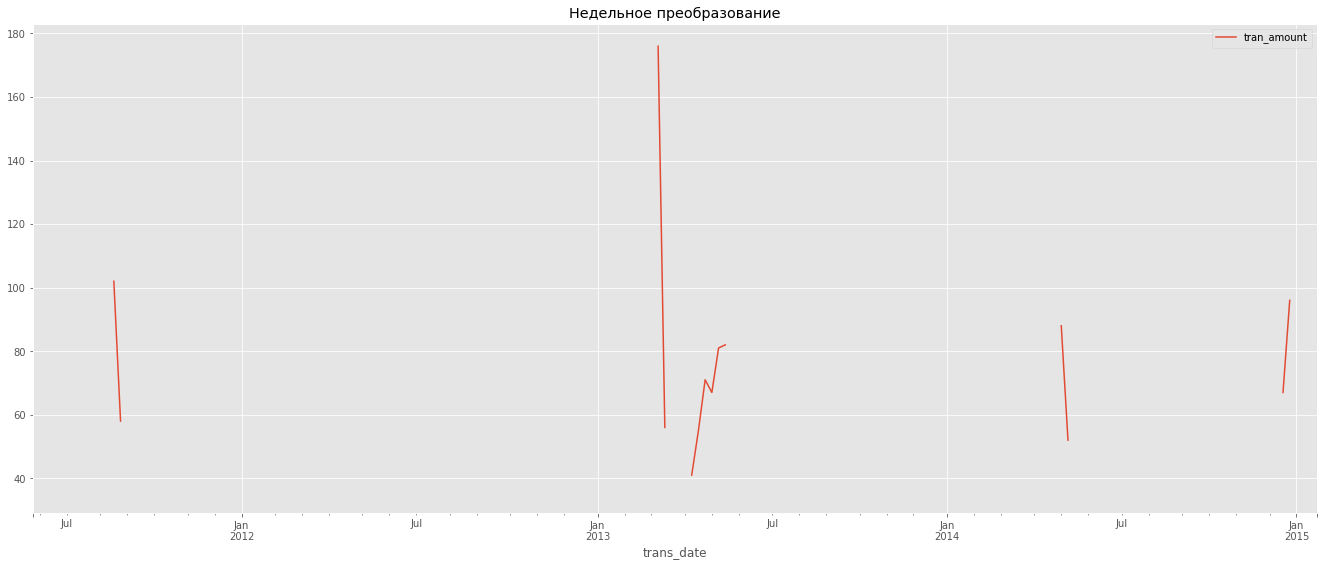

In [62]:
sample.resample("W").mean().plot()
plt.title('Недельное преобразование');


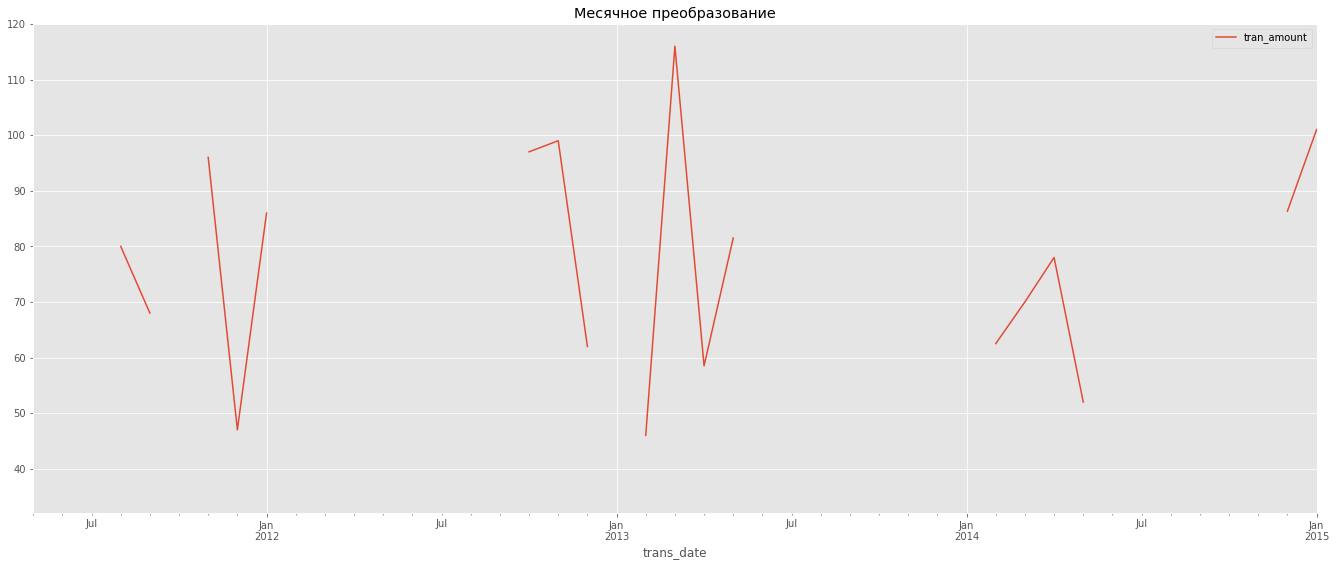

In [63]:
sample.resample("M").mean().plot()
plt.title('Месячное преобразование');

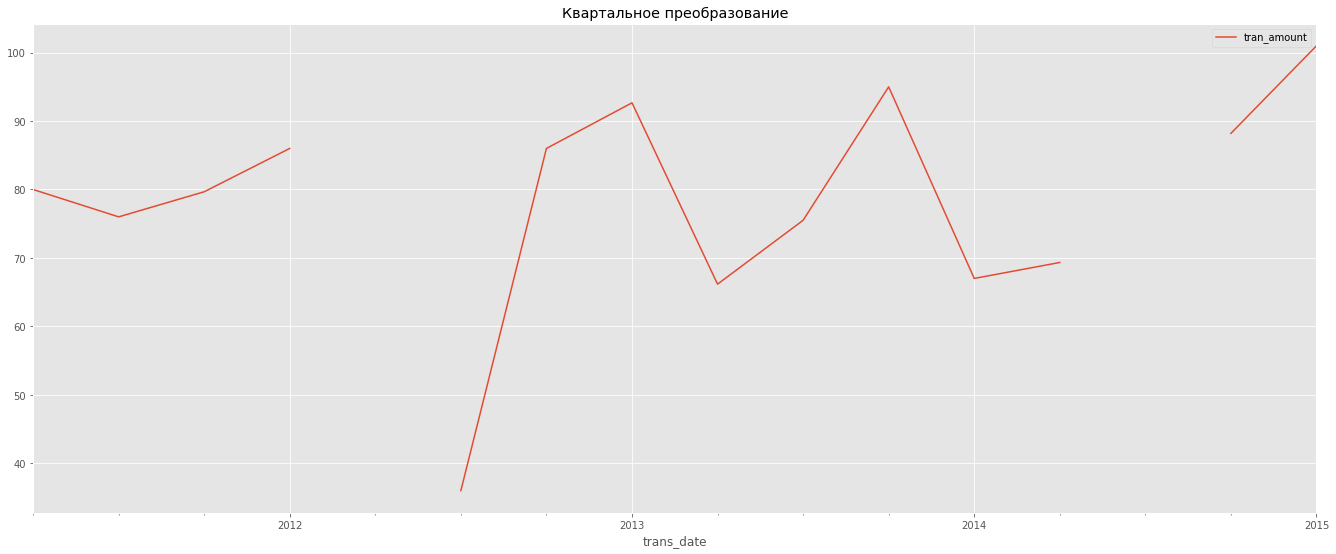

In [64]:
sample.resample("Q").mean().plot()
plt.title('Квартальное преобразование');

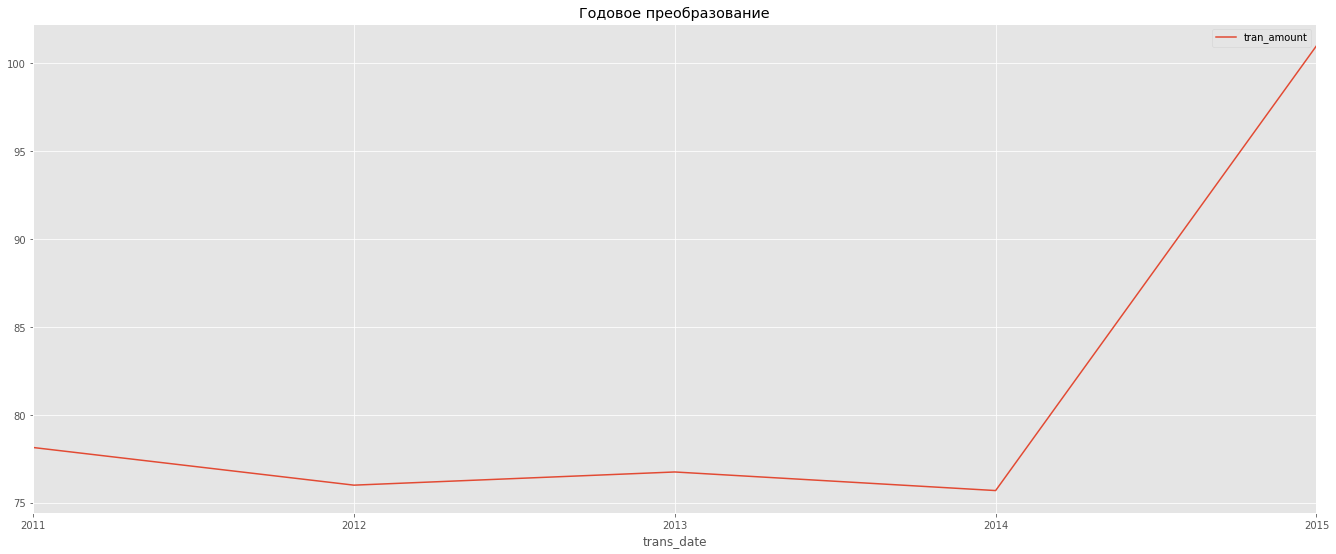

In [65]:
sample.resample("Y").mean().plot()
plt.title('Годовое преобразование');

Как мы видим, агрегация позволила сделать из непериодичных данных периодичные, но при этом данных осталось очень мало. Этот пример скорее иллюстративный. В такой ситуации скорее нужно искать альтернативную модель для работы со спорадическими данныи, чем агрегировать.

На самом деле, можно сделать такое преобразование и с периодичными данным -- просто чтобы понизить гранулярность ваших данных. Это может быть удобно и/или требоваться по задаче. Например, если наблюдения за объёмами продаж некоторого товара есть на каждый час, то просуммировать на дни вполне логично. Особенно если есть наблюдения за много дней. 

In [66]:
import statsmodels.api as sm
data = sm.datasets.macrodata.load_pandas().data

In [67]:
#Преобразуем данные из колонок в индекс. В данном случае проще всего было сгенерировать самим последовательность кварталов, чтобы не мучаться с конвертацией столбцов
data.index = pd.date_range(start = '01.01.1959', periods = len(data), freq='Q')
display(data)
data = data.drop(columns = ['year', 'quarter'])

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-12-31,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-03-31,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-06-30,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


В pandas можно генерировать индексы специального вида -- period. Этот тип данных в отличие от предыдущего характеризуетсяименно продолжительностью, а не точкой во премени. Периоды существуют множества видов -- день, конец месяца, начало месяца, начало квартала и т.д. Подробный список можно найти по [ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects). Также весьма полезным бывает создать собственный календарь и генерировать периоды из него. Например, если необходимо сгенерировать только рабочие дни в России, то можно выделить дни праздников и официальных выходных, и pandas сможет это учитывать при генерации рабочих дней. Подробнее об этом можно прочесть в документации.

Timestamp можно конвертировать в period. Но не во все, а, насколько я понял, только в базовые. То есть те, которые не привязаны к старту или концу.

In [68]:
pd.Timestamp("01.01.2002").to_period("M")

Period('2002-01', 'M')

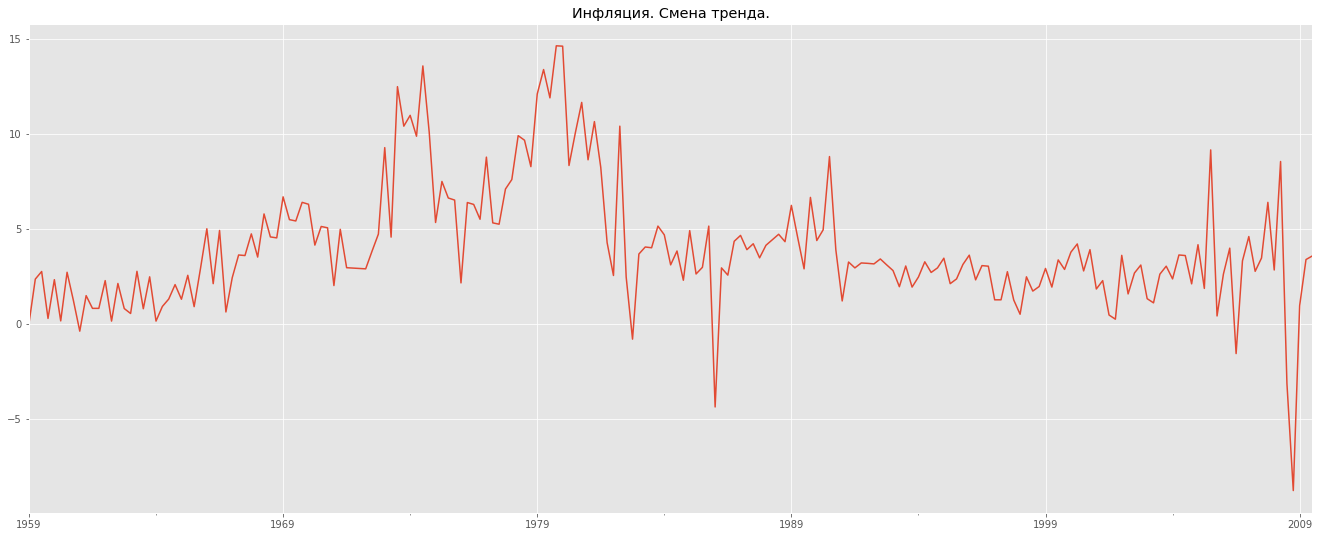

In [69]:
data.infl.plot()
plt.title('Инфляция. Смена тренда.');

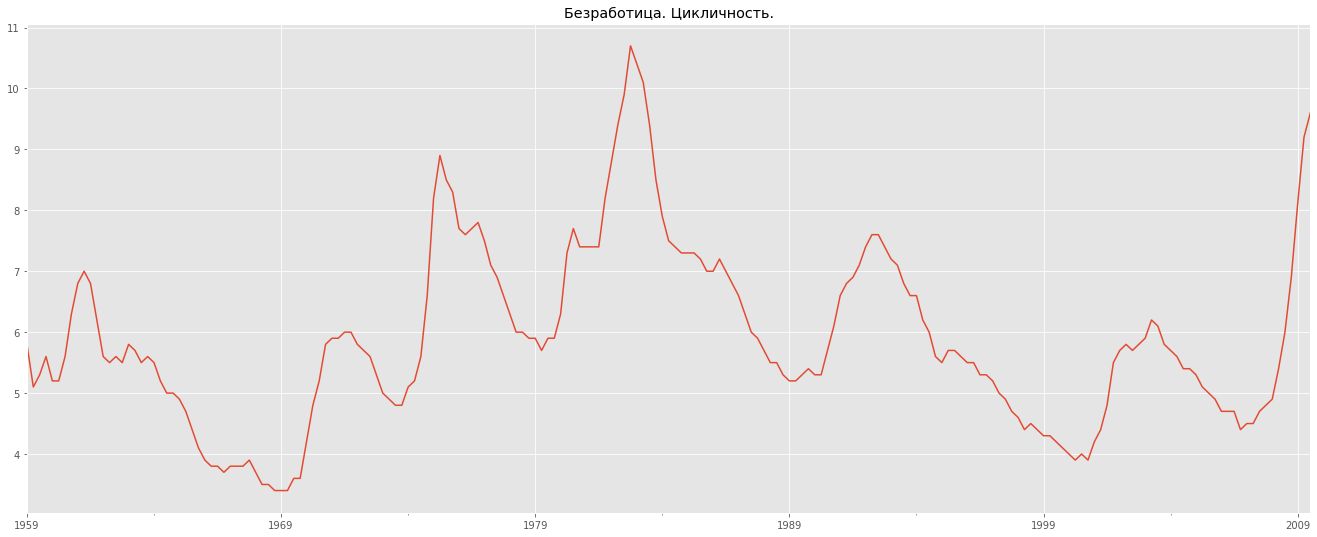

In [70]:
data.unemp.plot()
plt.title('Безработица. Цикличность.');

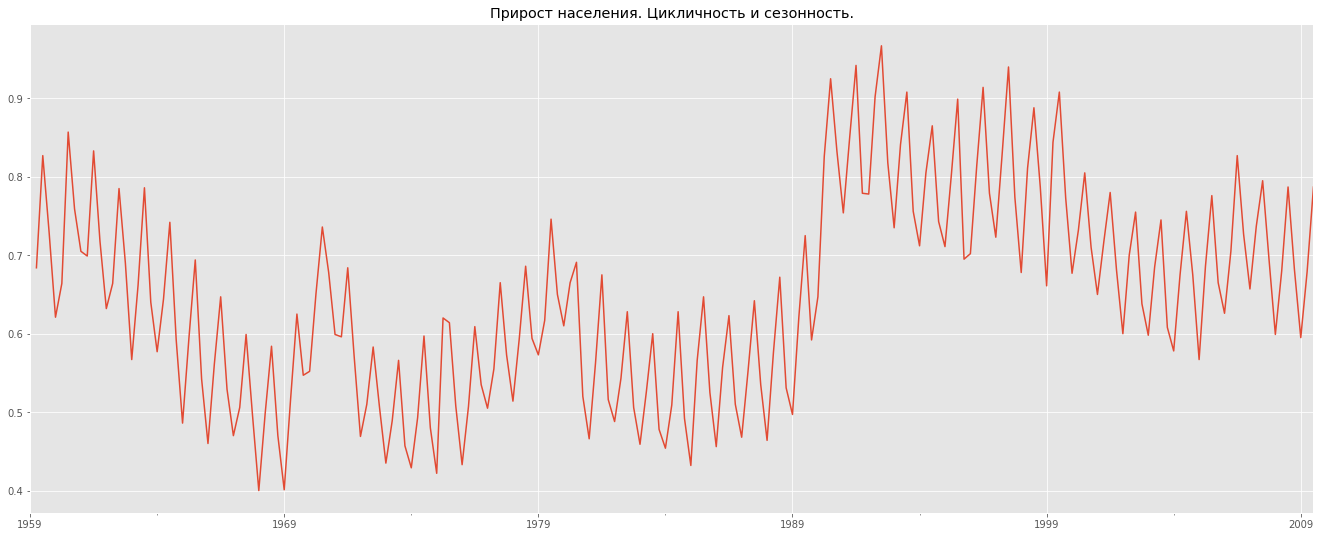

In [71]:
data.loc[:,'pop'].diff().plot()
plt.title('Прирост населения. Цикличность и сезонность.');

## Стационарность

Одной из важнейших характеристик случайного процесса является стационарность. Различают два вида стационарности -- в широком и в узком смысле.  Случайный процесс $X_{t}$ называется стационарным (statiоnary, стационарным в узком смысле), если все его конечномерные распределения инвариантны относительно сдвигов, т.е. для любых наборов моментов времени $t_{1}, \ldots, t_{n}$, любых вещественных $x_{1}, \ldots, x_{n}$ и любого $h>0$,


$$\mathbb{P}\left\{X_{t_{1}} \leq x_{1}, \ldots, X_{t_{n}} \leq x_{n}\right\}=\mathbb{P}\left\{X_{t_{1}+h} \leq x_{1}, \ldots, X_{t_{n}+h} \leq x_{n}\right\}$$

Грубо говоря, совместные распределения на любых двух равных по длине временных отрезках равны друг другу. Но очевидно, что в реальной жизни такие процессы найти весьма сложно, хотя и очень хотелось бы. В определении слабой стационарности  (wide sense stationary, weakly stationary, covariance stationary, second-order stationary) предлагается ослабить предыдущее условие. Пусть постоянными во времени будут не все характеристики распределения, а только некоторые моменты. Так, если у случайного процесса математическое ожидание постоянно во времени, и кроме того, для любых $h>0, s, t \in \mathbb{R}$ выполнено

$$Cov(X_{t+h}, X_{s+h})=Cov(X_t, X_s)$$


то процесс является слабостационарным. То есть у всех точек равное математическое ожидание, равная дисперсия, а ковариации равны для точек, разнесённых на равные отрезки времени. Нетрудно заметить, что в случае гауссовских процессов из слабой стационарности может следовать сильная, но во всех остальных случаях -- только в обратную сторону.

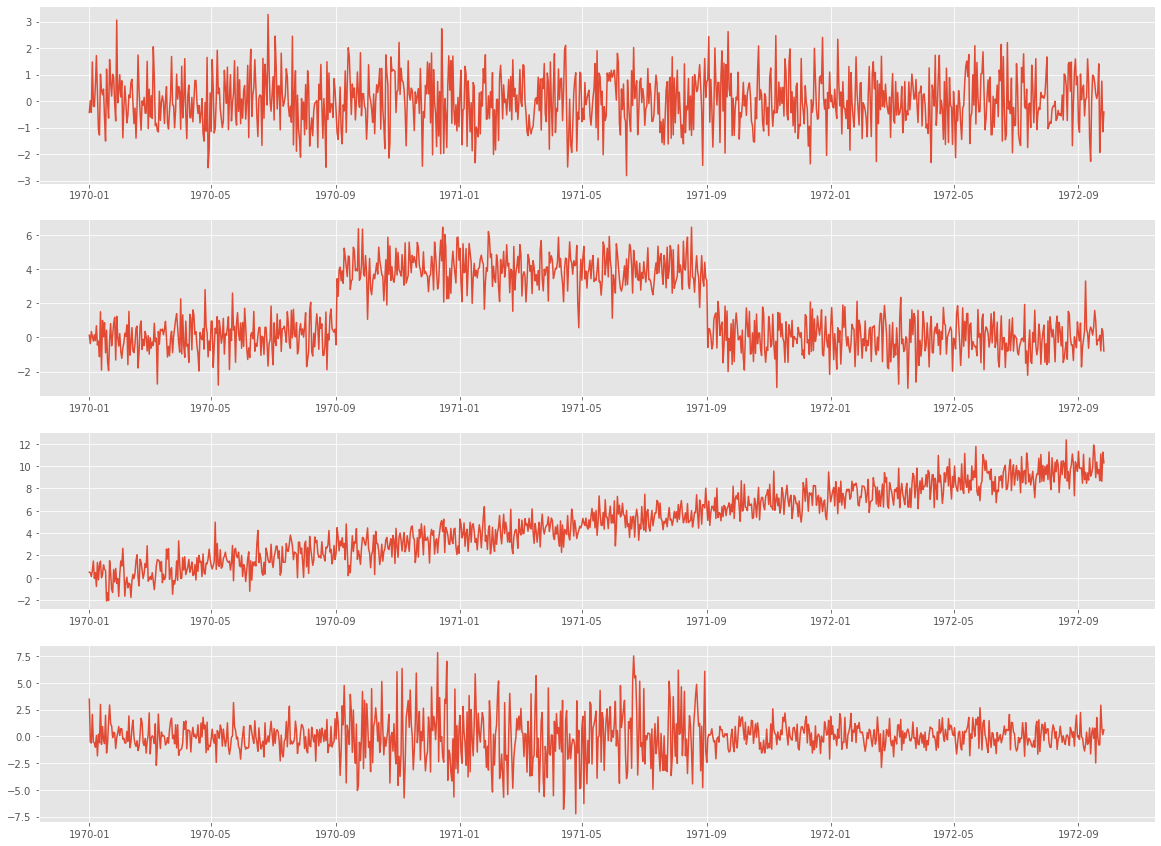

In [72]:
import numpy as np
n_sim = 1000
fig, ax = plt.subplots(nrows=4, figsize=(20,15))
index = pd.date_range(start='01.01.1970', periods=n_sim, freq='D')

ax[0].plot(pd.Series(np.random.normal(size=n_sim), index=index))
ax[1].plot(pd.Series(
    np.random.normal(size=n_sim) +
    (index > '1970-09') * 4 - 
    (index > '1971-09') * 4, 
    index=index))
ax[2].plot(pd.Series(np.random.normal(size=n_sim) + np.arange(n_sim)/100, index=index))

ax[3].plot(pd.Series(
    np.random.normal(scale=1 +
    (index > '1970-09') * 2 - 
    (index > '1971-09') * 2, size=n_sim) ,
    index=index))

## Корреляционные характеристики

У случайных процессов существует специальная характеристика, показывающая силу линейных взаимосвязей внутри них. Соответственно, по временным рядам (траекториям этих случайных процессов) мы можем построить оценки этих характеристик. Давайте поговорим о том, что они из себя представляют и как их вычислять.

Автокорреляцией k-го порядка будем называть величину $corr(y_t, y_{t-k})$. Самый простой способ оценить эту величину -- подсчитать выборочный коэффициент корреляции  $\hat{corr}(y_t, y_{t-k})$. Также можно построить парную регрессию и зять корень из коэффициента детерминации, но это будет ровно то же самое. Обычно вычисляют значения для значений $k \in \{1,\cdots,K\}$ и строят график. О том, как использовать информацию о линейных связях для построения моделей, мы поговорим позже. А пока взглянем на график ACF (Autocorrelation function)

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

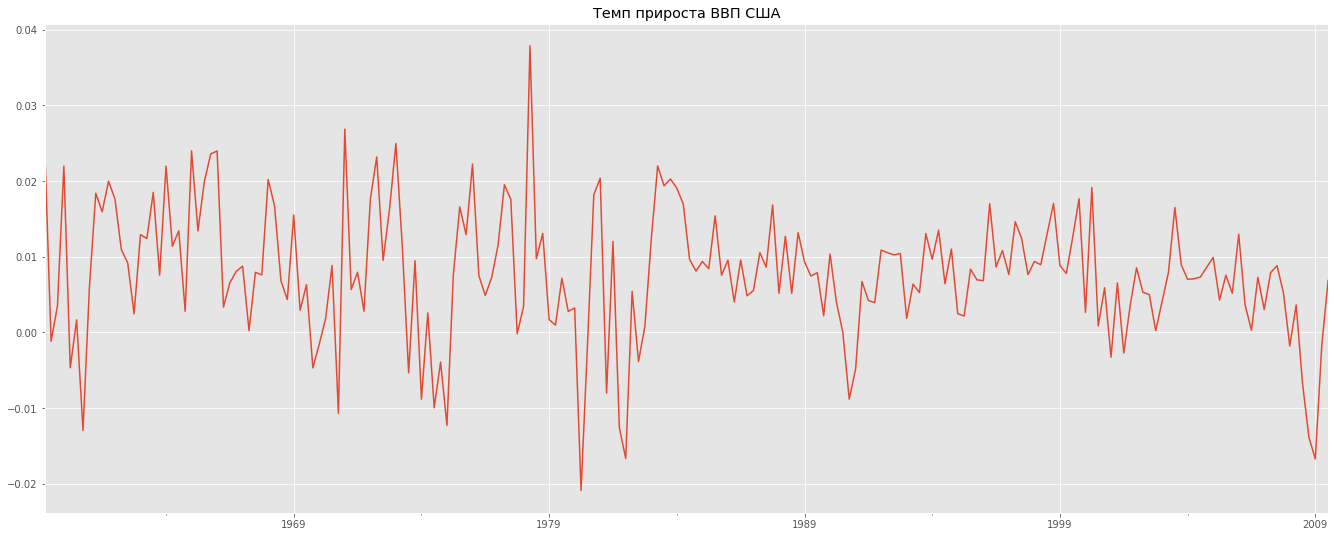

In [74]:
# Темп прироста ВВП
g_rate = (data.realgdp.diff() / data.realgdp).dropna()
g_rate.plot()
plt.title("Темп прироста ВВП США");

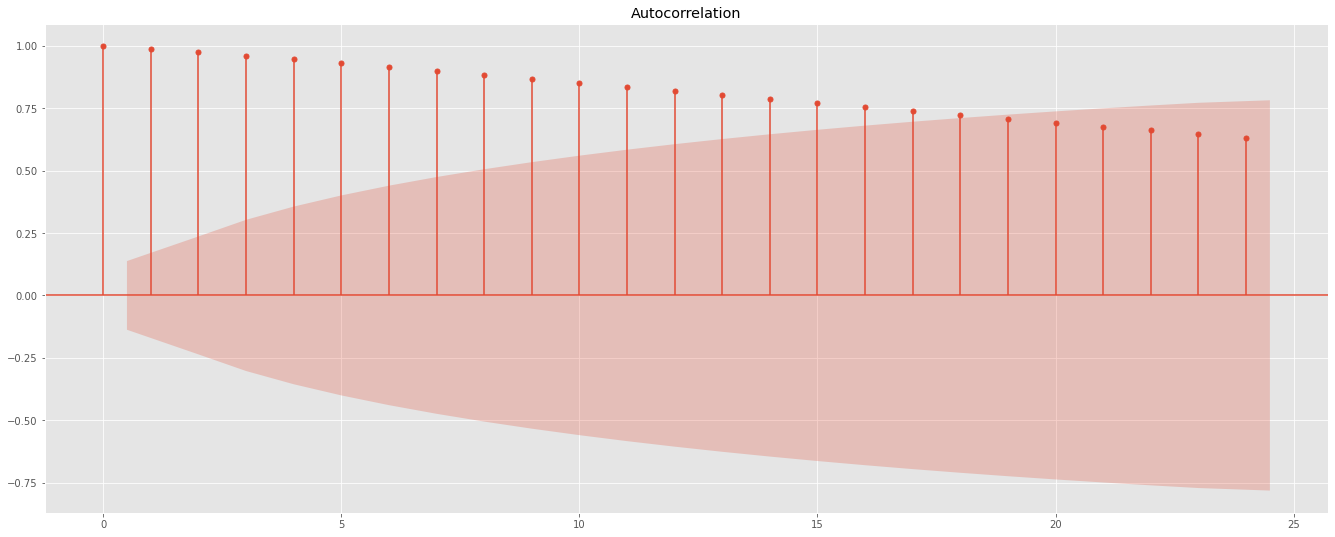

In [75]:
plot_acf(data.realgdp);

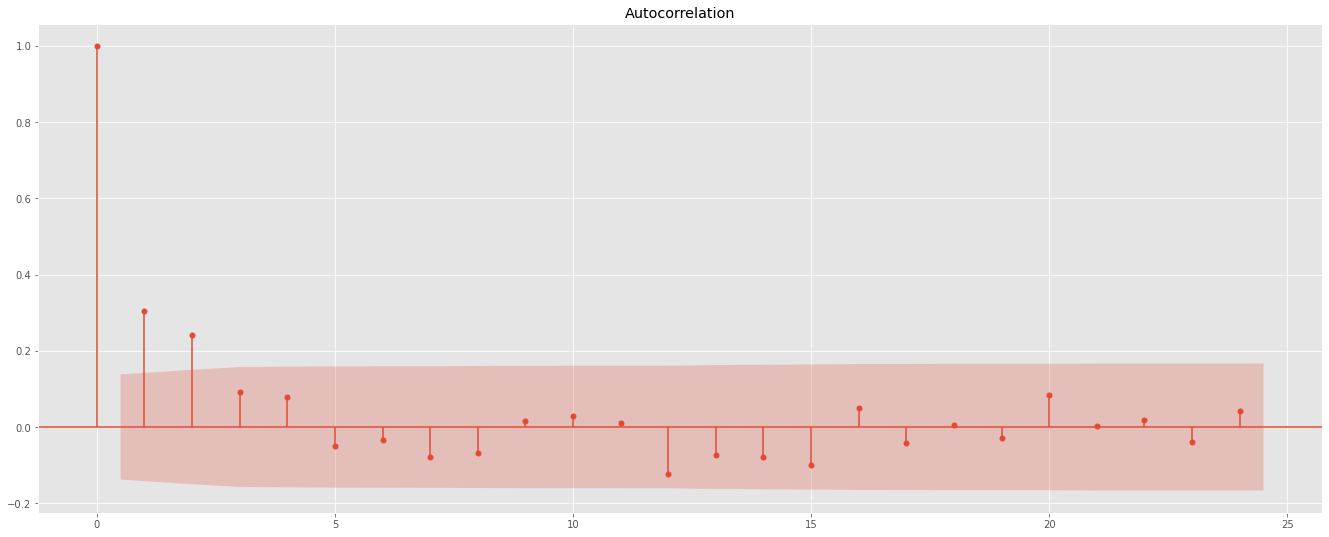

In [76]:
plot_acf(g_rate);

Вообще говоря, если мы взглянем на формулу автокорреляции, она может показаться неполной. Да, мы смотрим на связь переменной и её лагированного значения, но при этом не учитываем всё, что было между ними. Хотелось бы в дополнение к обычной корреляции знать и условную: $corr(y_t, y_{t-k}| y_{t-1}, y_{t-2}, \cdots, y_{t-k+1})$. Для её нахождения существуют разные методы. Из основных -- численное решение системы уравнений Yule-Walker  или построение регрессий (рассмотрим подробнее в контексте ARIMA). Нарисуема пару графиков PACF (Partial Autocorrelation Function)



In [77]:
from statsmodels.graphics.tsaplots import plot_pacf

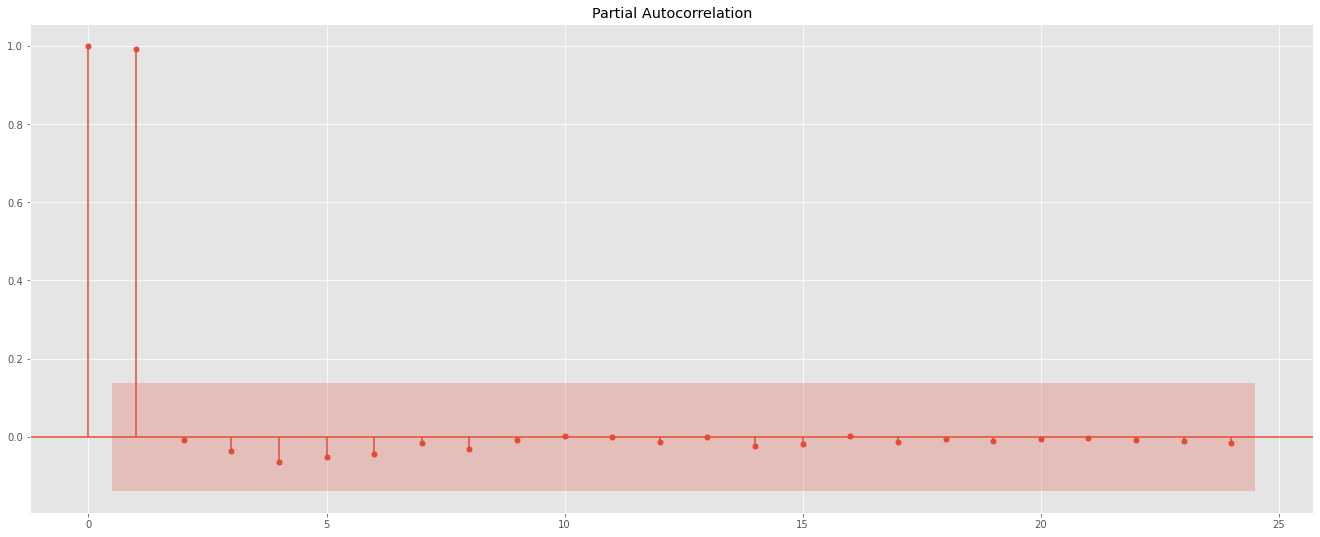

In [78]:
plot_pacf(data.realgdp);

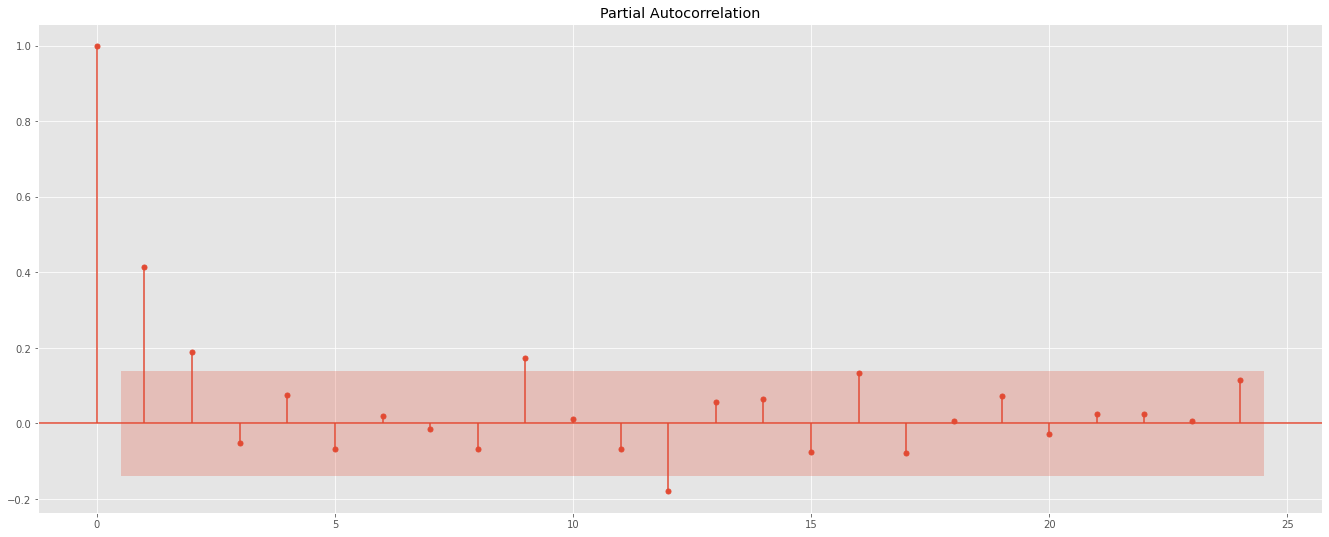

In [79]:
plot_pacf(data.realgdp.diff().dropna());

## STL-декомпозиция

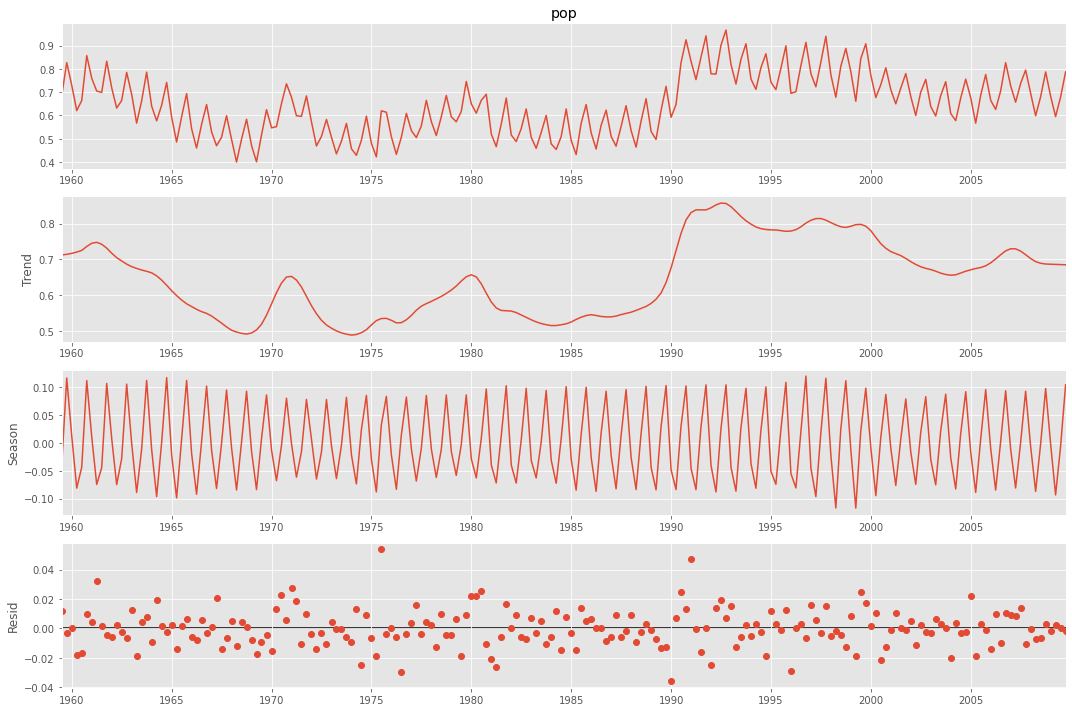

In [80]:
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(data.loc[:,'pop'].diff().dropna(), seasonal=5)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)



In [81]:
res.seasonal

1959-06-30   -0.040279
1959-09-30    0.116039
1959-12-31    0.012008
1960-03-31   -0.081087
1960-06-30   -0.043868
                ...   
2008-09-30    0.097275
2008-12-31   -0.002768
2009-03-31   -0.093207
2009-06-30   -0.006456
2009-09-30    0.103836
Freq: Q-DEC, Name: season, Length: 202, dtype: float64

In [82]:
res.trend

1959-06-30    0.712122
1959-09-30    0.713884
1959-12-31    0.716622
1960-03-31    0.720196
1960-06-30    0.724826
                ...   
2008-09-30    0.686792
2008-12-31    0.686272
2009-03-31    0.685701
2009-06-30    0.685170
2009-09-30    0.684610
Freq: Q-DEC, Name: trend, Length: 202, dtype: float64

## Обработка пропусков

Обработка пропусков во временных рядах связана всё с той же проблемой: данные связаны по времени. Это с одной стороны помогает, а с другой стороны мешает. Разберём некоторые наиболее значимые кейсы.

#### Смотрим на контекст!

Часто само происхождение данных или непосредственно задача диктует правила обработки пропусков. Рассмотрим пример ниже. Вам представлен график недельных цен на некоторый вид химического сырья в некотором регионе мира. В данном случае вполне логично интерпретировать пропуски как "цена не изменилась", поэтому можно заполнить пропуски просто последним доступным значением. С одной стороны это, конечно, снижает дисперсию данных, но при этом он обоснован.

In [94]:
flat = pd.read_csv('data/sem_2/weekly_flat.csv', index_col=0)
flat.index = pd.to_datetime(flat.index)

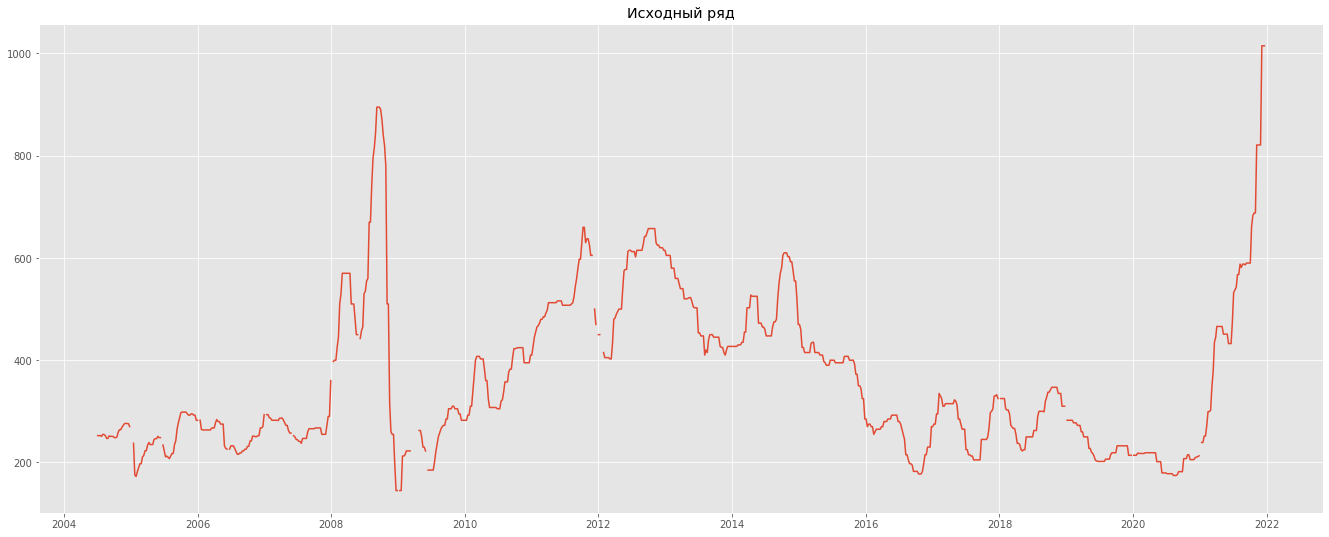

In [95]:

plt.plot(flat)
plt.title('Исходный ряд');

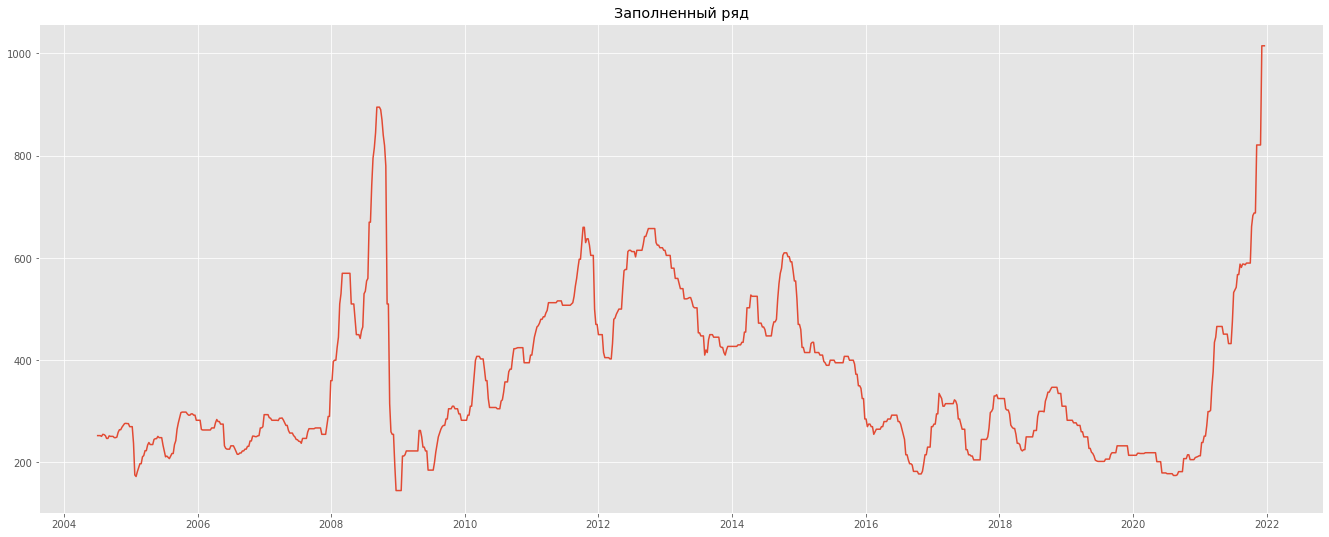

In [96]:

plt.plot(flat.ffill())
plt.title('Заполненный ряд');

#### Смотрим на структуру данных!

Любые паттерны данных и их структура могут помочь в заполнении пропусков. Во-первых, если в данных есть тренд.

In [97]:
mask = np.random.binomial(1, 0.3, size=len(data)) > 0 
gdp_true = data.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

<AxesSubplot:>

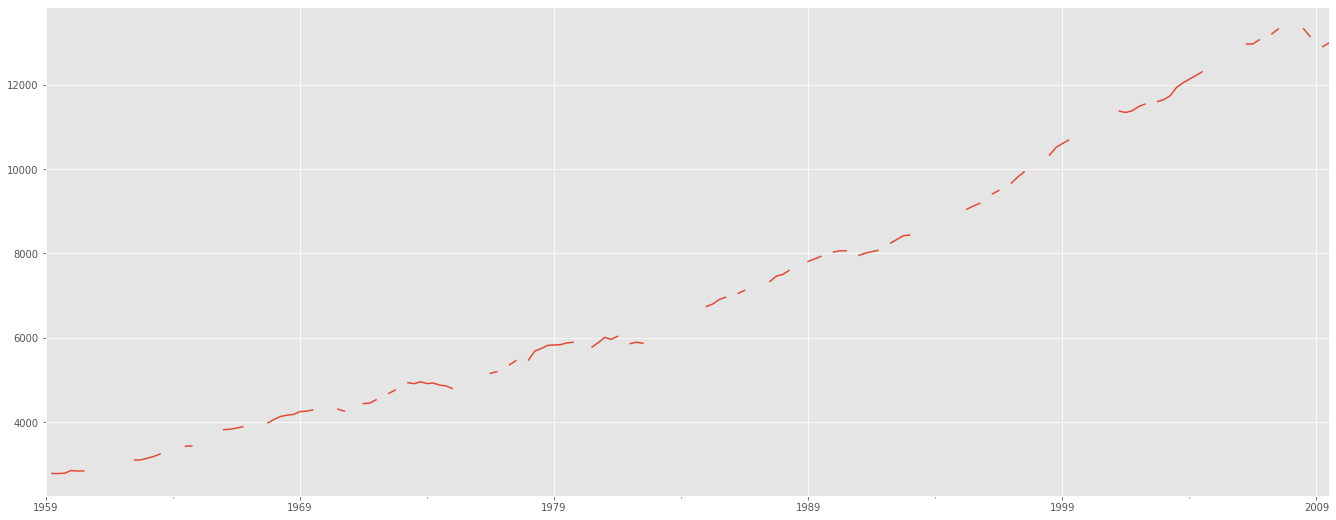

In [98]:
gdp_nan.plot()

<AxesSubplot:>

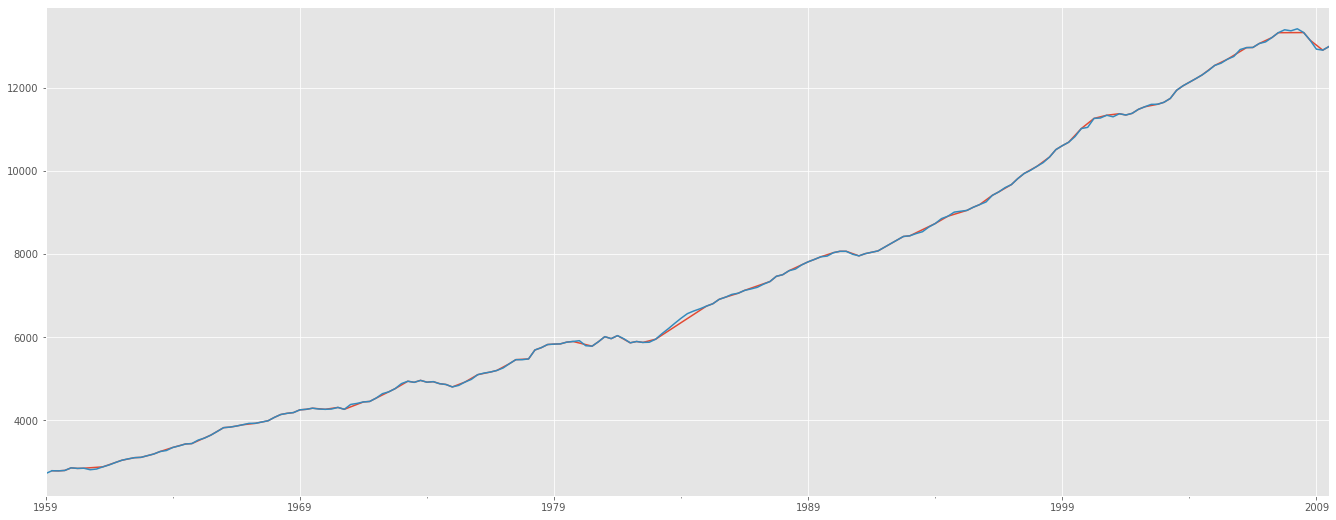

In [99]:
gdp_nan.interpolate(method='linear').plot()
gdp_true.plot()

<AxesSubplot:>

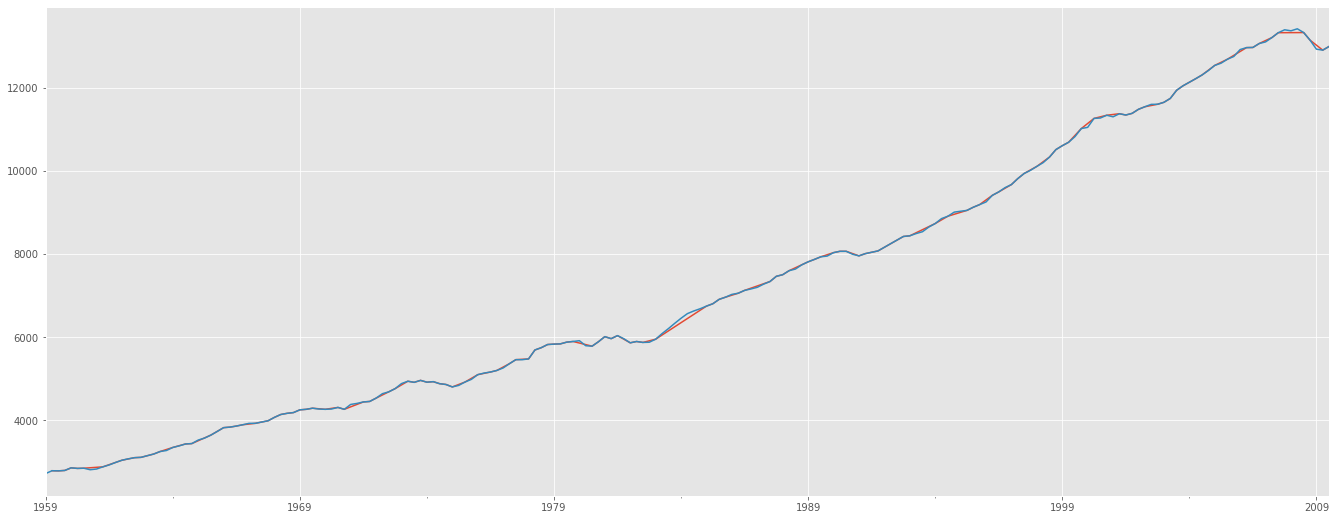

In [100]:
gdp_nan.interpolate(method='time').plot()
gdp_true.plot()

In [101]:
# MAE заполнения
np.abs(gdp_nan.interpolate(method='time') - gdp_true)[mask].mean()

32.674801927034196

В случае, если данные носят сезонный характер, это тоже можно использовать. Например, заполнять последним доступным значением в аналогичном сезоне или усреднять по двум соседним аналогичным сезонам.

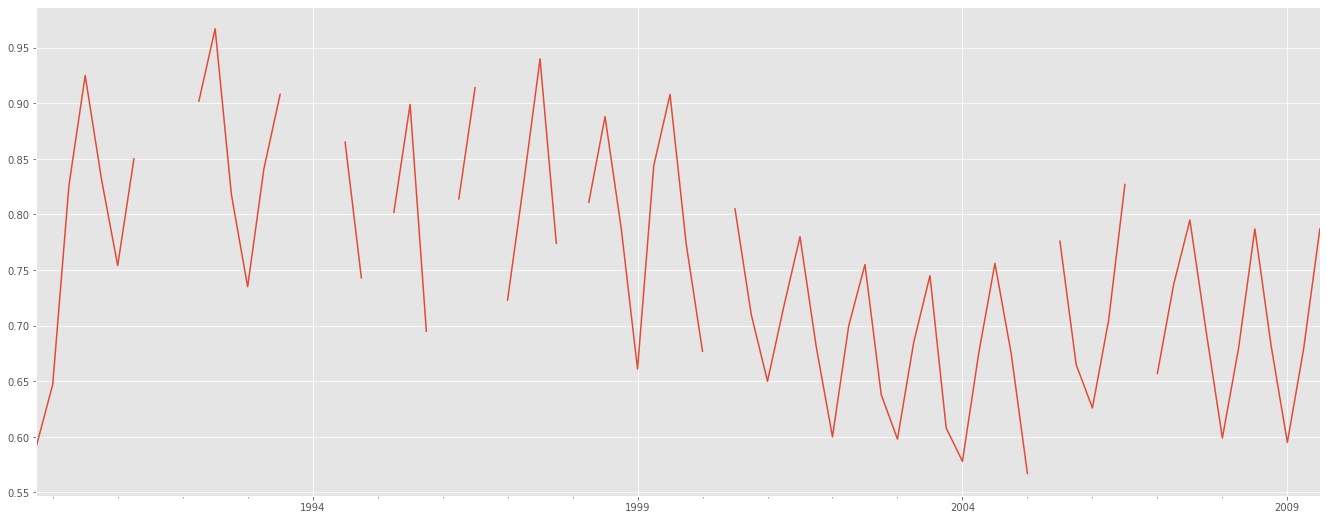

In [103]:
seasonal = data.loc[:,'pop'].diff().dropna().tail(80).copy()

mask = np.random.binomial(1, 0.1, size=len(seasonal)) > 0 

seasonal_nan = seasonal.copy()
seasonal_nan[mask] = np.nan
seasonal_nan.plot()

previous = seasonal.shift(4)
future = seasonal.shift(-4)


# Усредним предудыщий и следующий периоды в аналогичном сезоне
seasonal_nan[seasonal_nan.isna()] = ((previous + future) / 2)[seasonal_nan.isna()]

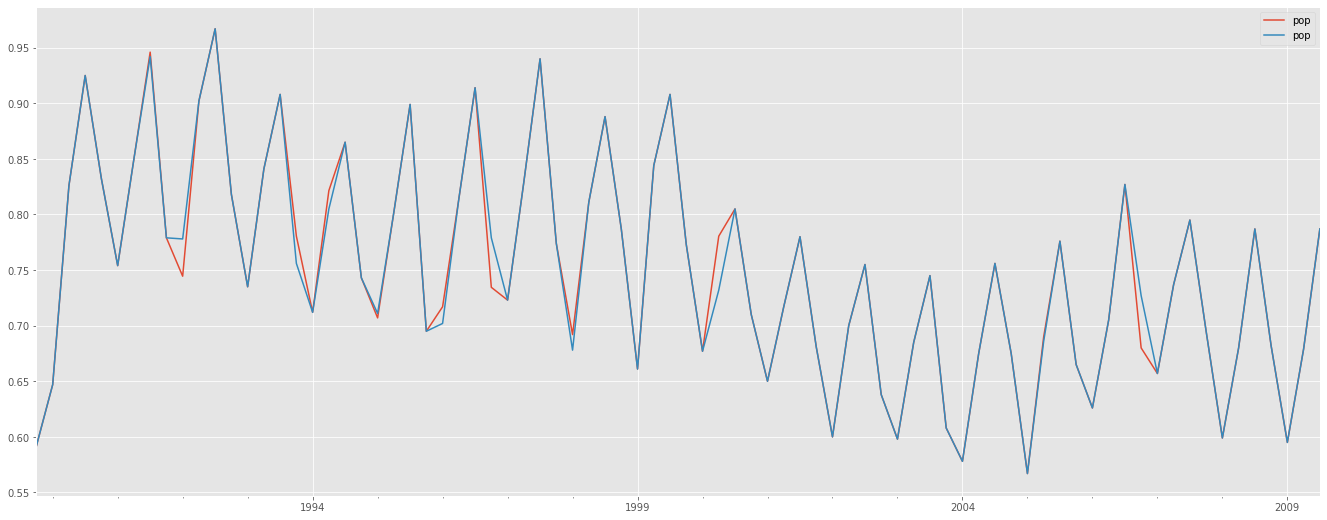

In [105]:
seasonal_nan.plot()
seasonal.plot()
plt.legend()

## Блок о том, почему наш курс не нужен

Первое о чём следует задуматься: а чем, собственно, ряды отличаются от стандартной задачи машинного обучений? Короткий ответ: особо ничем, но есть нюанс. В целом, задачу прогнозирования рядов можно решать как обычную табличную задачу. Сложность обычно в том, что под каждую задачу нужно отдельно возиться с генерацией признаков и порой простая модель временного ряда оказывается выразительнее кучи сгенерированныъ признаков. Сейчас мы попробуем повозиться немного с одной из таких задач. Данные взяты с [kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv). Будем прогнозировать потребление электроэнергии в Испании.

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_correlations
from sktime.forecasting.all import temporal_train_test_split
from sklearn.ensemble import RandomForestRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from catboost import  CatBoostRegressor
import numpy as np



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')

# Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])


In [107]:
# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')

# Преобразуем даты
weather.index = pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')
target = data.loc[:,'total load actual'].resample('D').sum()


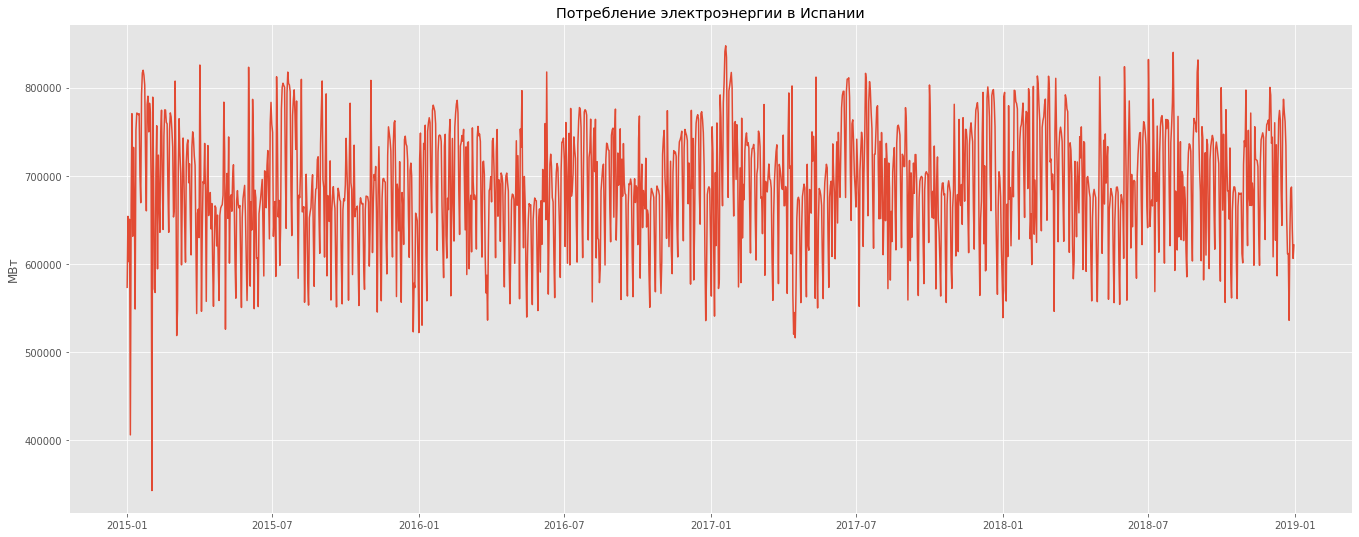

In [109]:
# Найти 
plt.plot(target)
plt.title('Потребление электроэнергии в Испании')
plt.ylabel('МВт');

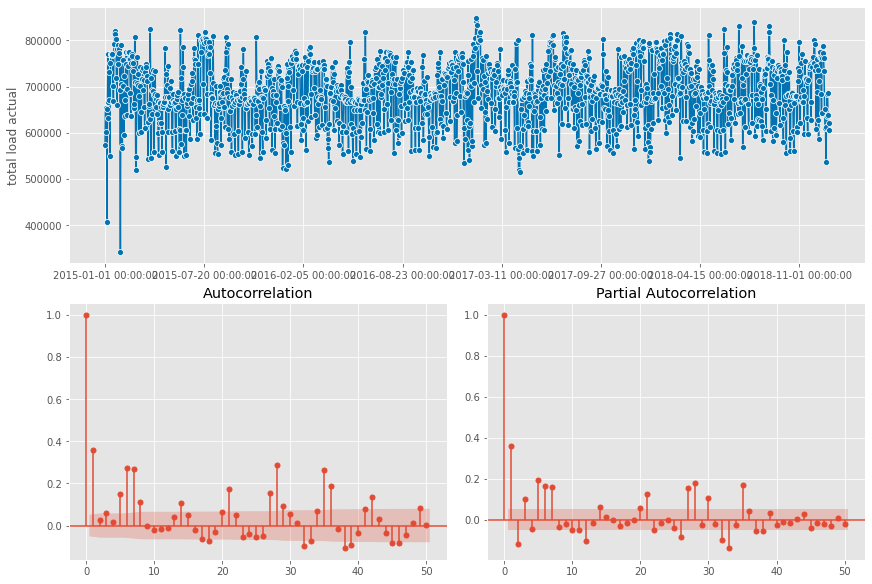

In [110]:
plot_correlations(target, lags=50);

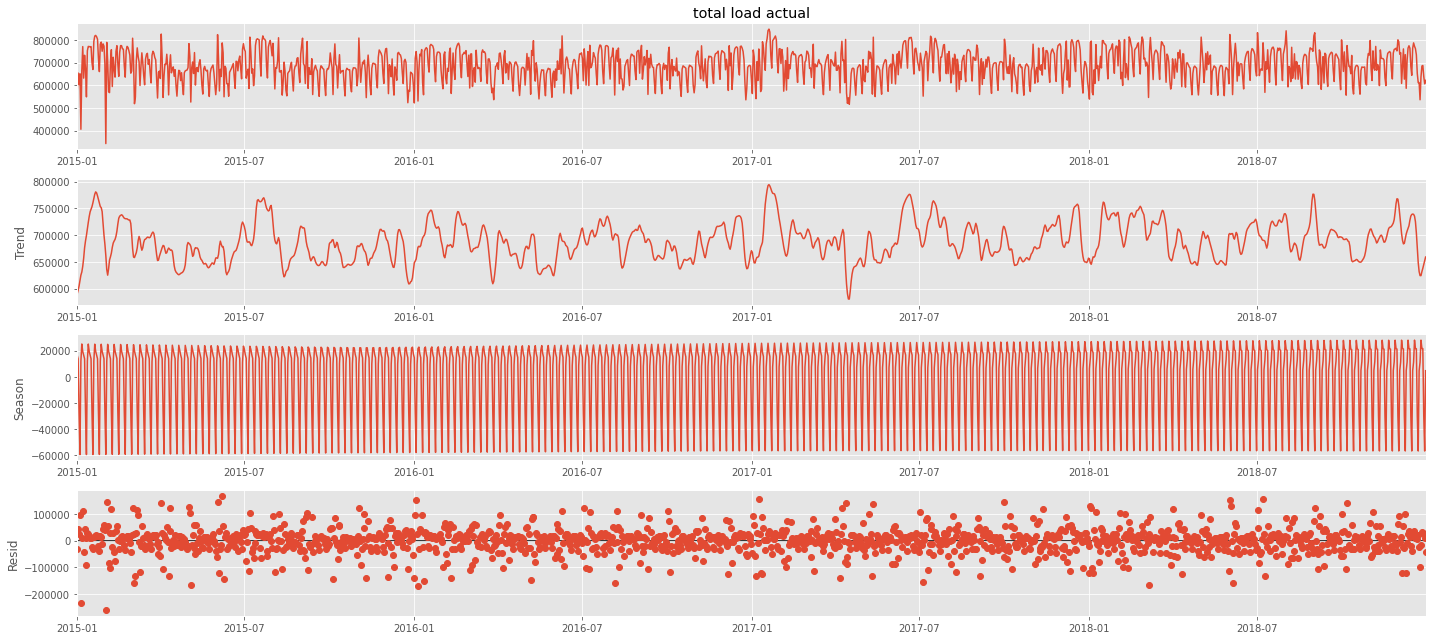

In [112]:
from statsmodels.tsa.seasonal import STL

stl = STL(target, seasonal=365)
res = stl.fit()
res.plot();


In [113]:
import holidays

es_holidays = holidays.Spain()

X = pd.DataFrame()

WINDOW = 10

X['target'] = data.loc[:,'total load actual'].resample('D').sum()
X['y_L1'] = X['target'].shift(1)
X['y_L2'] = X['target'].shift(2)
X['y_L3'] = X['target'].shift(3)
X['y_L4'] = X['target'].shift(4)

X['y_L6'] = X['target'].shift(6)
X['y_L7'] = X['target'].shift(7)
X['y_L31'] = X['target'].shift(31)
X['y_L364'] = X['target'].shift(364)
X['y_L365'] = X['target'].shift(365)
X['y_L366'] = X['target'].shift(366)

# X['rolling_mean'] = X['target'].rolling(WINDOW).mean().shift(1)

X['month'] = X.index.month
X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.index.weekday >= 5
X['season'] = X.index.month%12 // 3 + 1
X['temp'] = data.loc[:,'temp'].resample('D').min() * (X.season == 1) + data.loc[:,'temp'].resample('D').max() * (X.season == 3) + data.loc[:,'temp'].resample('D').mean() * ((X.season == 2) | (X.season == 4))
# X['cos'] = np.cos((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))
X['sin'] = np.sin((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

X['is_holiday'] = X.index.to_series().apply(lambda x: x in es_holidays)

X = X.dropna()

y = X.target
X = X.drop(columns=['target'])

In [114]:

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

model = CatBoostRegressor(iterations=30, 
                          depth=2, 
                          learning_rate=0.5)

model.fit(X_train, y_train, cat_features=['month', 'day', 'weekday', 'is_weekend', 'is_holiday', 'season'], verbose=0)
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)


0.046709081907116465

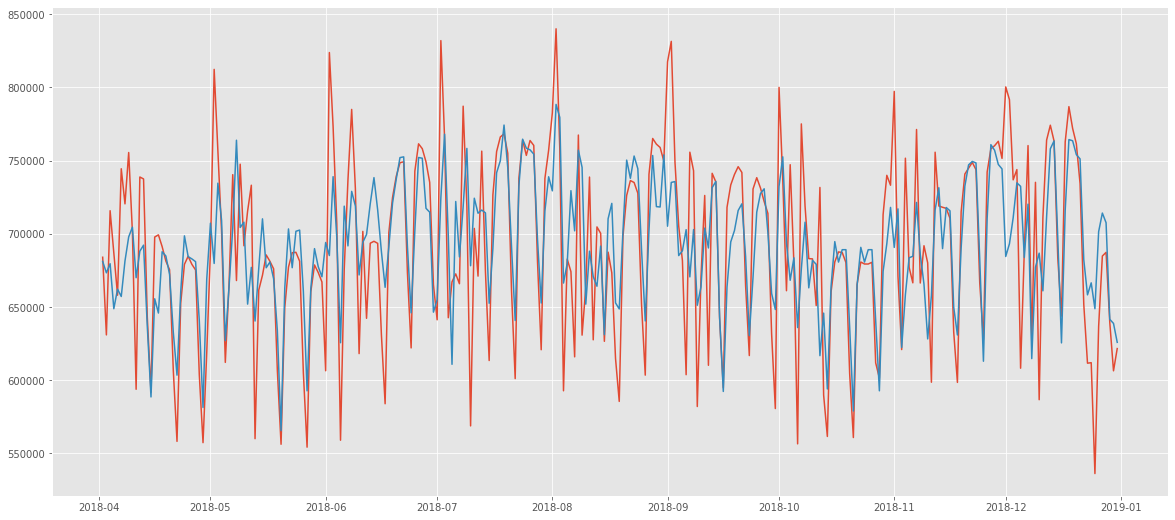

In [115]:
plt.plot(y.tail(len(y_pred)))
plt.plot(y_pred)